In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sps
from tqdm import tqdm
rng = np.random.default_rng()

In [2]:
from graph import RandomGraph

In [3]:
%load_ext autoreload
%autoreload 2

## Исследование динамики системы для $H_i \sim \mathcal{N}(0, \Sigma)$ (многомерный случай)

В этой части задачи предпочтения агентов скоррелированы: $H_i \sim \mathcal{N}(\vec 0, \Sigma)$, где $\Sigma$ — некоторая недиагональная матрица ковариаций. Логично предположить, что в таком случае агенты окажутся более связанными, зависимыми друг от друга, в связи с чем переходы между крайними состояниями станут более резкими, а разница траекторий — более выраженной. Посмотрим, так ли это. 

Для начала сгенерируем матрицу ковариаций — она должна быть симметричной и неотрицательно определённой. Делать это будем по следующей схеме:
1. Будем генерировать её в виде $\Sigma = BB^T + \alpha I$, где $B$ — матрица $N \times N$, строки которой — неортогональные единичные векторы. Второе слагаемое $\alpha I$ нужно во избежание ошибок, связанных с машинной арифметикой, его наличие позволяет гарантировать положительность всех собственных чисел ($\alpha$ — какой-то малый коэффициент, выбранный в коде равным $0{,}01$). 
2. Выберем $\beta \in (0, 1]$. Назовём это число степенью корреляции. 
3. Сгенерируем векторы $\vec b_i$ — строки матрицы $B$, соответствующие вершинам. Для этого построим дерево обхода в ширину: пусть $V_0$ — множество вершин нулевого уровня, $V_1$ — 1-го уровня, $\dots V_m$ — $m$-го уровня. Выберем для всех вершин $0$-го уровня $\vec b_i$ как произвольный вектор на единичной сфере. Для остальных же поступим так: пусть $u$ — предок вершины $v$ в дереве обхода в ширину, тогда выберем её вектор так:
$$
    \vec b_u = \beta \vec b_v + (1 - \beta) \cdot \vec b_v^{\bot},
$$
где $\vec b_v^{\bot}$ — произвольный вектор на единичной сфере, ортогональный $\vec b_v$. Таким образом, $\vec b_u$ — случайный единичный вектор такой, что $\langle \vec b_u, \vec b_v \rangle = \beta$.
4. Получившаяся матрица является неотрицательно определённой (из-за наличия регуляризации — даже положительно определённой). Заметим, что в такой схеме $\rho(H_i, H_j) = \langle \vec b_i, \vec b_j \rangle \:\, \forall \, i, j$, и корреляция между соседними вершинами $\langle \vec b_i, \vec b_j \rangle = \beta$, а также $\forall \, i \:\: \mathsf{D}{H_i} = 1 + \alpha \approx 1$.

Дальше можно использовать эту матрицу корреляций для генерации из любого многомерного распределения, например, нормального или распределения Стьюдента. 

Минус такой схемы, конечно, в том, что мы никак не учитываем циклы: вершины могут быть связаны ребром и в то же время находиться далеко друг от друга в дереве обхода, тогда они окажутся слабо скоррелированы, хотя, казалось бы, должно быть наоборот, ведь они соседние. Однако для наблюдения общей картины того, что происходит при изменении "скоррелированности" отдельных полей, такого приближения должно быть достаточно.

In [4]:
N = 5000
l = 4
J = 0.5
alpha = 2.185
G_Poisson = RandomGraph(N, sps.poisson(l))
G_zipf = RandomGraph(N, sps.zipf(alpha))

In [5]:
beta_grid = np.array([0, 0.9, 0.95, 0.98, 0.99, 0.995])
H_max = 4
H_grid = np.linspace(-H_max, H_max, 300)

Точно так же, как в первой части, будем плавно изменять $H$, сначала повышая его, а потом понижая.

6it [20:07, 201.33s/it]


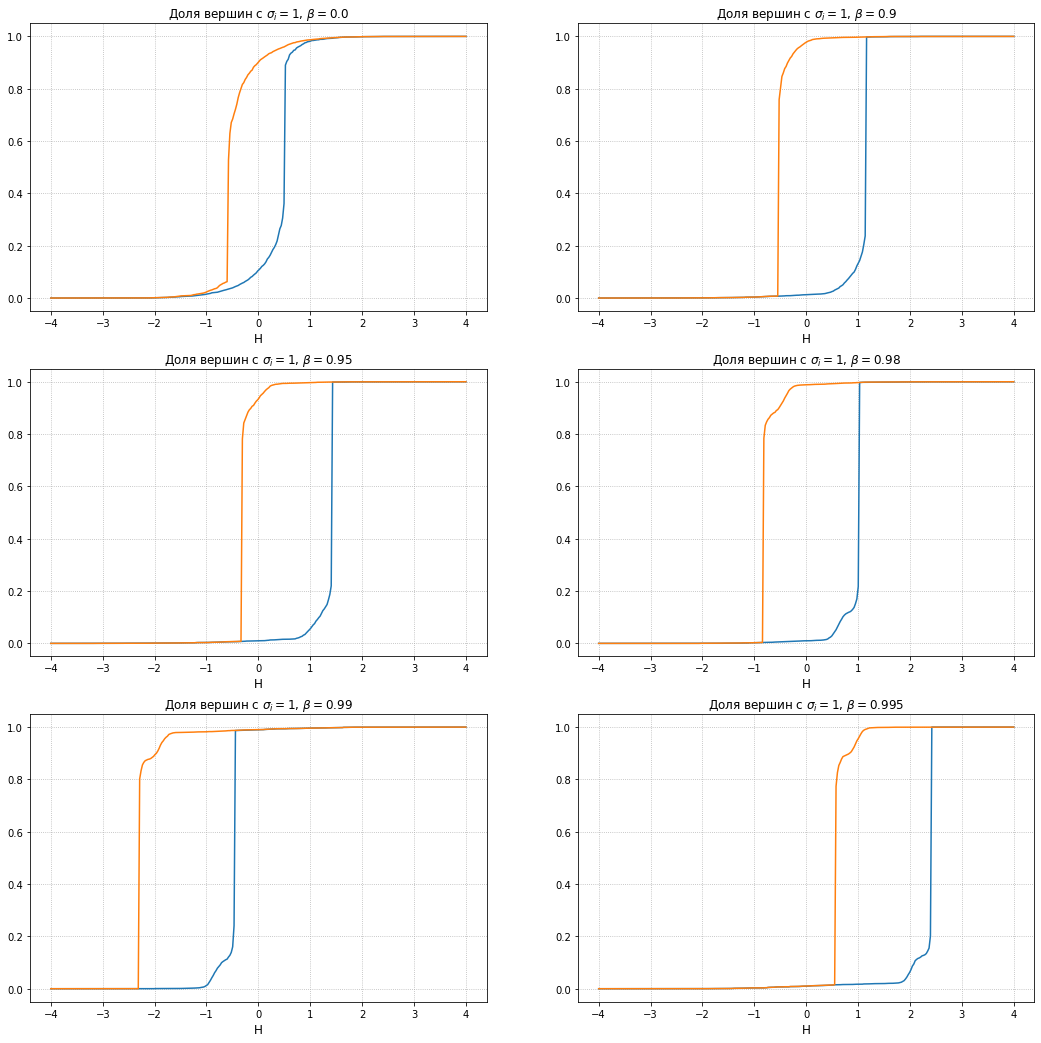

In [6]:
plt.figure(figsize=(18, 18))
for index, beta in tqdm(enumerate(beta_grid)):
    low_to_high, high_to_low = G_Poisson.get_trajectories(J, H_grid, beta, 'multivariate_norm')
    
    plt.subplot(3, 2, index + 1)
    plt.plot(H_grid, low_to_high, label='при повышении H')
    plt.plot(np.flip(H_grid), high_to_low, label='при снижении H')
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\beta = {0}$'.format(round(beta, 3)))

При увеличении $\beta$ графики становятся более резкими, более выраженным становится последний лавинообразный переход, когда меняют своё состояние большая часть вершин (до $80 \%$ уже при $\beta \sim 0{,}9$). Этот эффект очень похож на то, что происходит в одномерном случае при уменьшении дисперсии $H_i$. Кроме того, при очень высоких значениях $\alpha$, порядка $\sim 0{,}95$, графики начинают "ломаться": появляется заметное смещение относительно нуля, возможное из-за того, что несколько $H_i$ оказались отклонены от нуля, а остальные с ними сильно скоррелированы; вместо гладкой траектории в начале перехода формируется отдельная "ступенька", которая, возможно, отвечает переходу вершин с малыми степенями (0 или 1).

Посмотрим теперь на граф со степенным распределением.

In [7]:
beta_grid = np.array([0, 0.9, 0.95, 0.98, 0.99, 0.995])
H_max = 5
H_grid = np.linspace(-H_max, H_max, 300)

6it [20:59, 209.85s/it]


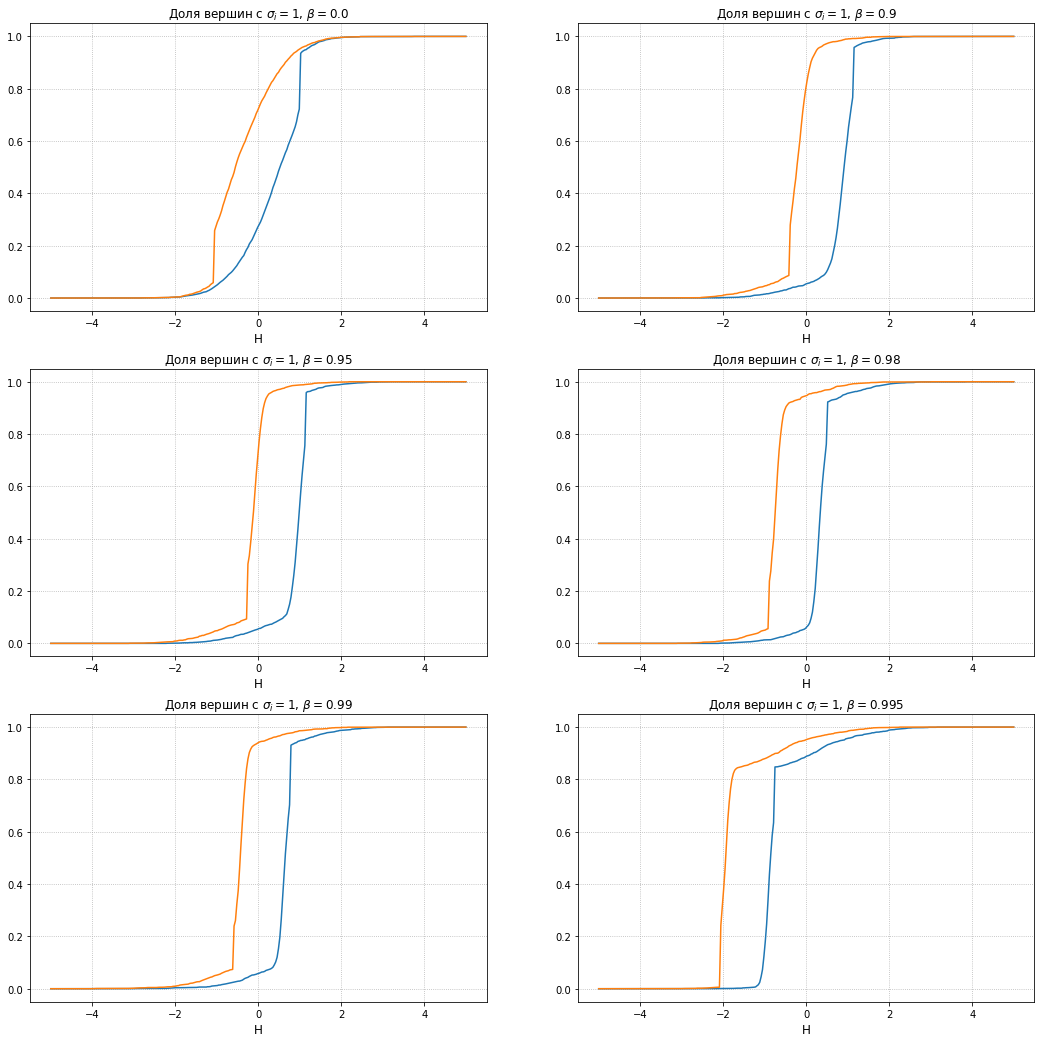

In [9]:
plt.figure(figsize=(18, 18))
for index, beta in tqdm(enumerate(beta_grid)):
    low_to_high, high_to_low = G_zipf.get_trajectories(J, H_grid, beta, 'multivariate_norm')
    
    plt.subplot(3, 2, index + 1)
    plt.plot(H_grid, low_to_high, label='при повышении H')
    plt.plot(np.flip(H_grid), high_to_low, label='при снижении H')
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\beta = {0}$'.format(round(beta, 3)))

Для степенного графа также заметно отличие от одномерного случая: переходы становятся более резкими, чему соответствует увеличение линий наклона на графиках. Помимо этогоб на графиках в конце процесса более выражена становится "ступенька" — после лавины с переворачиванием хабов система всё ещё не переходит в состояние, в котором прямая и обратная траектории совпадают, определённая разница сохраняется ещё некоторое время, из-за чего область между траектории оказывается зигзагообразной.

Ещё любопытно отметить, что основная часть переходов становится хоть и более быстрой, но не лавинообразной: размер лавины остаётся неизменным вне зависимости от степени корреляции и составляет примерно 15% всех вершин. Также местами теряется симметрия относительно начала координат (заметно это, например, при $\beta = 0{,}95$).

## Исследование динамики системы для $H_i \sim t_{\nu}(0, \Sigma)$ (многомерный случай)

Многомерное распределение Стьюдента со степенью свободы $\nu$ случайного вектора размерности $N$ со средним $\mathbf{\mu}$ и матрицей формы $\mathbf{\Sigma}$ имеет плотность
$$
    p(\mathbf{x}) = \frac{\Gamma\left( \frac{\nu + N}{2} \right)}{\Gamma\left( \frac{\nu}{2} \right) (\pi\nu)^{\frac{N}{2}} |\mathbf{\Sigma}|^{\frac{1}{2}}} \left[ 1 + \frac{1}{\nu} (\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu}) \right]^{-\frac{\nu + N}{2}}
$$
Здесь $\mathbf{\Sigma}$ — не матрица ковариаций, это матрица ковариаций лишь вектора из $\mathcal{N}(0, \mathbf{\Sigma})$, из которого генерируется элемент выборки. Сама же матрица ковариаций равна $\frac{\nu}{\nu - 2} \mathbf{\Sigma}$ — учтём это при работе с распределением.

Выберем параметр распределения равным $\nu = 4$ — при этом все дисперсии и ковариации конечны. Будем, как и в случае с нормальным распределением, варьировать степень корреляции. Начнём с пуассоновского графа.

In [19]:
nu = 4
beta_grid = np.array([0, 0.5, 0.8, 0.9, 0.95, 0.99])
H_max = 6
H_grid = np.linspace(-H_max, H_max, 300)

6it [20:07, 201.17s/it]


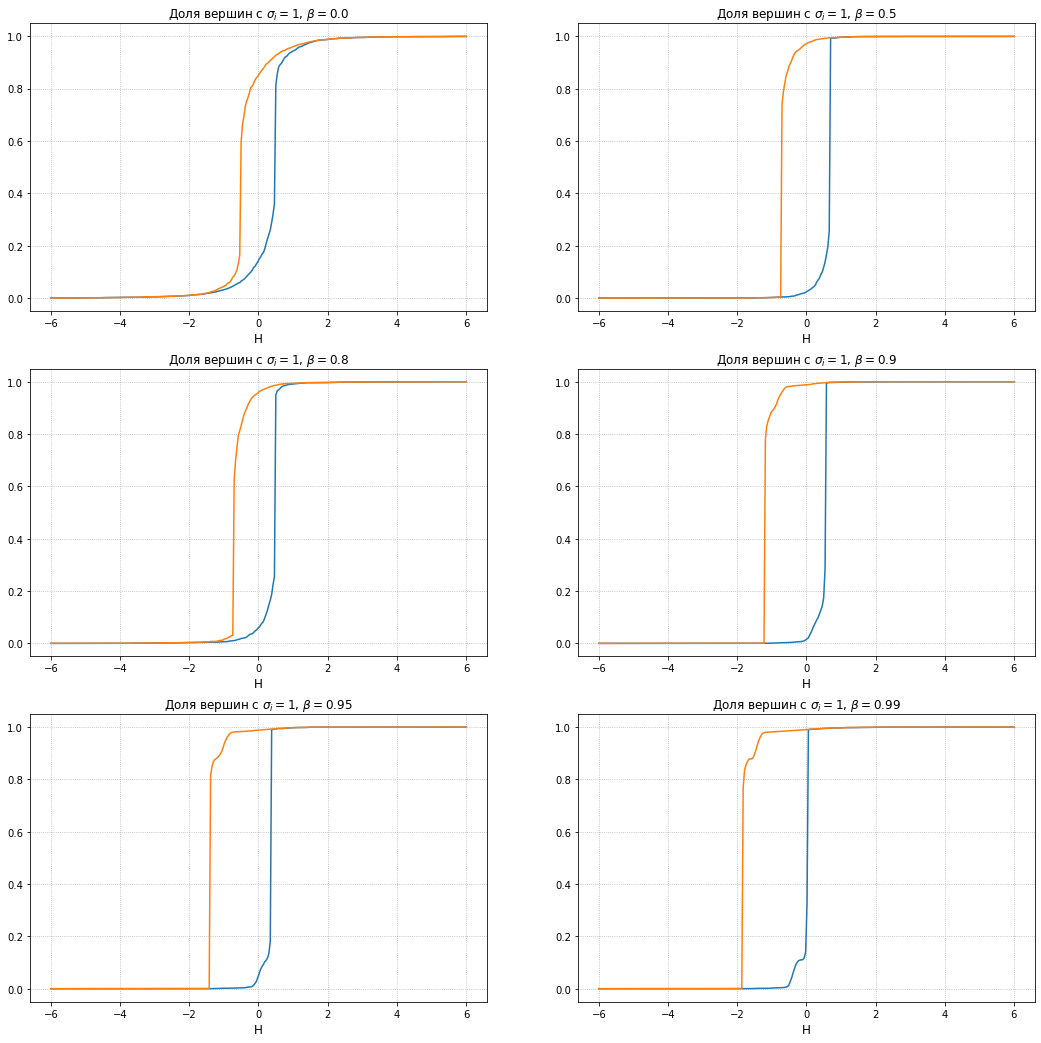

In [20]:
plt.figure(figsize=(18, 18))
for index, beta in tqdm(enumerate(beta_grid)):
    if index == 0:
        low_to_high, high_to_low = G_Poisson.get_trajectories(J, H_grid, nu, 'student')
    else:
        low_to_high, high_to_low = G_Poisson.get_trajectories(J, H_grid, beta, 'multivariate_student')
    
    plt.subplot(3, 2, index + 1)
    plt.plot(H_grid, low_to_high, label='при повышении H')
    plt.plot(np.flip(H_grid), high_to_low, label='при снижении H')
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\beta = {0}$'.format(round(beta, 3)))

Здесь разница становится заметна и при достаточно малых корреляциях ($\sim 0{,}5)$, и проявляется она в увеличении размера лавины: уже при $\beta = 0{,}5$ порядка $80\%$ вершин меняют своё состояние лавинообразно, переходя в состояние, где все вершины положительны/отрицательны. Аналогично нормальному распределению, начиная с некоторого достаточно большого значения график становится ещё более резким, и на начальном этапе начинает выделяться дополнительная ступенька, отвечающая, как я полагаю, переходу вершин малых степеней.

Теперь посмотрим, что происходит в случае графа со степенным распределением.

6it [20:59, 209.86s/it]


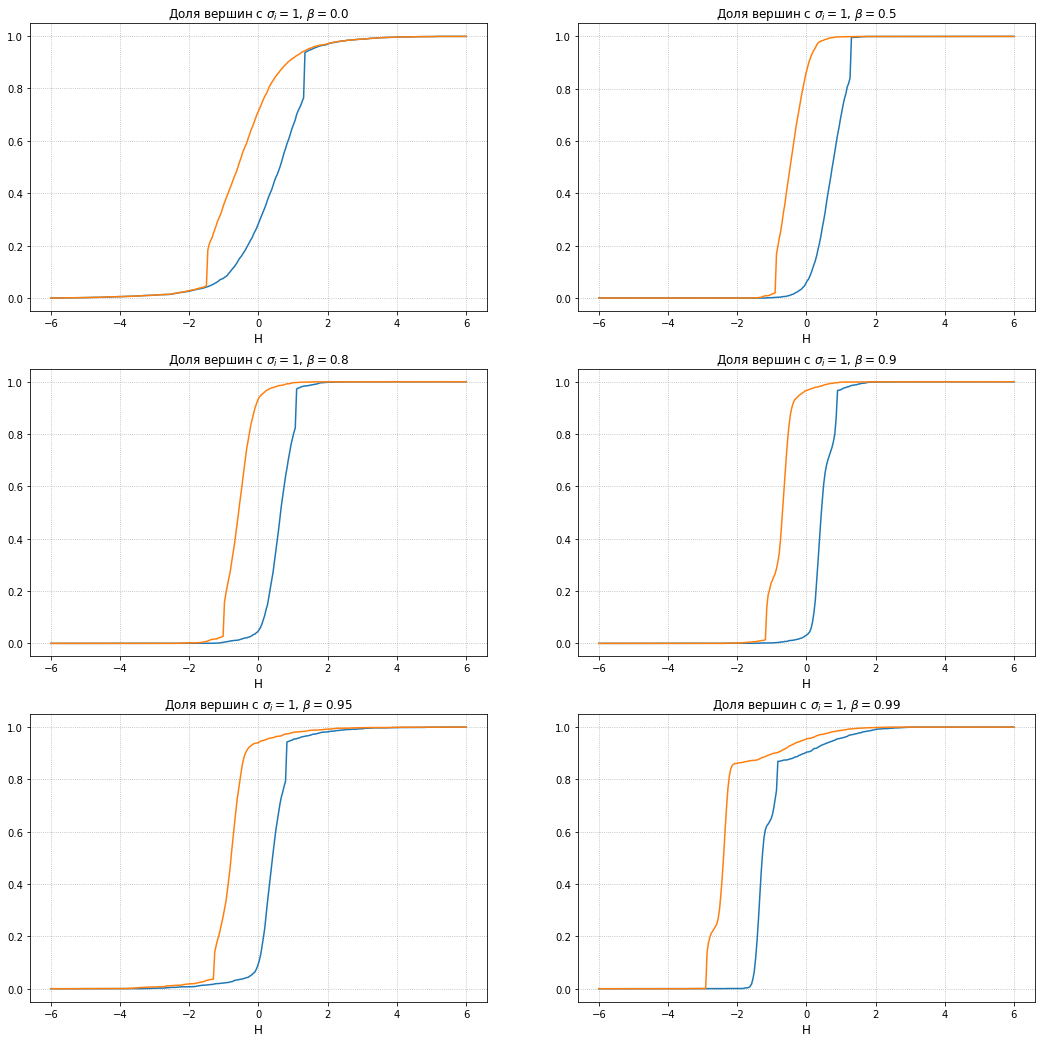

In [22]:
plt.figure(figsize=(18, 18))
for index, beta in tqdm(enumerate(beta_grid)):
    if index == 0:
        low_to_high, high_to_low = G_zipf.get_trajectories(J, H_grid, nu, 'student')
    else:
        low_to_high, high_to_low = G_zipf.get_trajectories(J, H_grid, beta, 'multivariate_student')
    
    plt.subplot(3, 2, index + 1)
    plt.plot(H_grid, low_to_high, label='при повышении H')
    plt.plot(np.flip(H_grid), high_to_low, label='при снижении H')
    plt.grid(ls=':')
    plt.xlabel('H', fontsize='large')
    plt.title(r'Доля вершин с $\sigma_i = 1$, $\beta = {0}$'.format(round(beta, 3)))

В целом ситуация похожа на то, что происходит в случае нормального распределения: переходы становятся более резкими, становятся заметны ступеньки в начале и в конце.

Преиодически здесь наблюдается любопытный эффект: при больших корреляциях графики перестают быть симметричными относительно начала координат, а вместо этого синхронизируются: средний спин при увеличении поля $m_{up}(H)$ и при уменьшении поля $m_{down}(H)$ оказываются связаны примерно как $m_{up}(H) = m_{down}(H - H^*)$. Не совсем ясно, с чем он может быть связан.

На самом деле, картина переходов оказывается очень сильно зависимой от того, какая именно матрица ковариации сгенерируется в начале и какие поля сгенерируются дальше с её помощью: если попробовать запускать процесс несколько раз, графики будут получаться разными. Поэтому описанный выше эффект, на мой взгляд, не стоит считать строгим следствием увеличения корреляций между соседями. Тем не менее, он довольно часто наблюдается.